<a href="https://colab.research.google.com/github/AmedeeRoy/BirdGAN/blob/main/code/basicGAN/basicGAN_20_steps_SV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


## load data

In [3]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime as dt
import time

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision as tv

In [4]:
from utils.tools import *

data = pd.read_table('./data/trips_SV_2008_10_min.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

colony = (-77.264, -11.773)
# colony =  (-32.392, -3.819)
data = format_data(data, colony, 5e4)
data = data[data.dist_colony > 1000]

padding = 20
traj = padding_data(data, padding)

In [5]:
class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        self.traj = traj
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        
        # select coordinates
        sample = self.traj[idx,:,:]

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [6]:
# hyperparameters
batch_size = 39

## reduce size dataset
train_set = TrajDataSet(traj, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [7]:
x =  next(iter(train_loader))

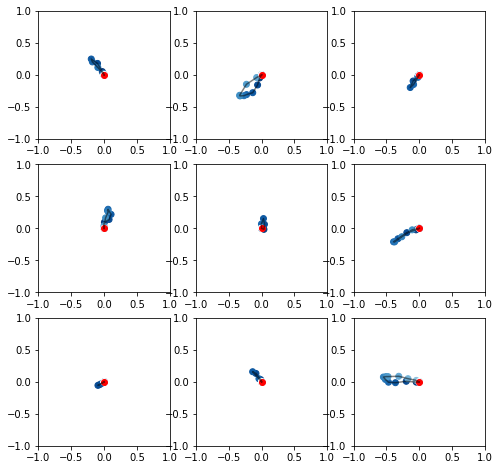

In [8]:
plt.figure(figsize = (8,8))
i = 4

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(x.numpy()[i,0,:], x.numpy()[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(x.numpy()[i,0,:], x.numpy()[i,1,:], c=np.arange(padding), cmap='Blues_r')
    plt.scatter(0,0, c = 'red')
    plt.xlim(-1,1)
    plt.ylim(-1,1)


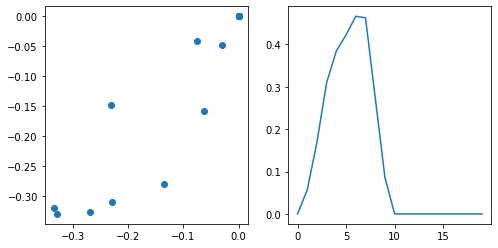

In [9]:
plt.figure(figsize = (8,4))

x = traj[0,0,:]
y = traj[0,1,:]

plt.subplot(1,2, 1)
plt.scatter(x, y)

plt.subplot(1,2, 2)
plt.plot(np.sqrt(x**2 + y**2))

## deep networks

Architecture guidelines for stable Deep Convolutional GANs (Radford et al. 2016)

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.



In [10]:
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## CNN

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(20, 10, kernel_size = 5, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(10),
            nn.ReLU(True),

            nn.ConvTranspose1d(10, 5, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(5),
            nn.ReLU(True),

            nn.ConvTranspose1d(5, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )
        

    def forward(self, z, batch_size):    
        out = self.cnn(z)
        return out

In [13]:
gen = CNNGenerator().to(device)
z = torch.rand((batch_size, padding, 1)).to(device) # (batch, seq, feature)

out = gen(z, batch_size)
out.shape

torch.Size([39, 2, 20])

In [14]:
class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            
            nn.Conv1d(2, 5, kernel_size = 5, stride = 1, padding = 2, bias = False),
            nn.BatchNorm1d(5),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(5, 10, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(10),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(10, 20, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(20),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(20, 1, kernel_size=5, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, batch_size):

        out = self.cnn(x)

        return out.squeeze(1)


In [15]:
dis = CNNDiscriminator().to(device)
dis(out, batch_size).shape

torch.Size([39, 1])

In [16]:
sum(p.numel() for p in gen.parameters())

1270

# LSTM

In [17]:
class LSTMGenerator(nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.
    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(1, 16, 1, batch_first=True, bias = True)
        self.linear = nn.Sequential(
                        nn.ReLU(),
                        nn.Linear(16, 16),
                        nn.ReLU(),
                        nn.Linear(16, 2),
                        nn.Tanh()
                      )

    def forward(self, x, batch_size):  

        h_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state
        c_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state

        # init LSTM cells  (batch, seq, feature)
        out, h_n = self.lstm(x, (h_0, c_0))
        out = self.linear(out)
        out = out.view(batch_size, 2, padding)
        return torch.cumsum(out, 2)

In [18]:
gen = LSTMGenerator().to(device)
z = torch.rand((batch_size, padding, 1)).to(device) # (batch, seq, feature)

out = gen(z, batch_size)
out.shape

torch.Size([39, 2, 20])

In [19]:
sum(p.numel() for p in gen.parameters())

1522

In [20]:
class LSTMDiscriminator(nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.
    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(2, 16, 1, batch_first=True)
        
        self.linear = nn.Sequential(
                        nn.Linear(16, 16),
                        nn.ReLU(),
                        nn.Linear(16, 1),
                        nn.Tanh()
                      )

    def forward(self, x, batch_size):  

        h_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state
        c_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #internal stat

        # init LSTM cells  (batch, seq, feature)
        out = x.view(batch_size, padding, 2)
        out, (h_n, c_n) = self.lstm(out, (h_0, c_0))
        out = self.linear(out)
        out = 1/(1 + torch.exp(-torch.mean(out, 1)))

        return out

In [21]:
dis = LSTMDiscriminator().to(device)
dis(out, batch_size).shape

torch.Size([39, 1])

In [22]:
class GAN :
  """
  This class creates a GAN with: 
   - a Generator network 
   - a Discriminator network
   - a Dataloader object from pytorch
  """
  def __init__(self, generator, discriminator, train_loader, device):
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)
    self.device = device
    self.train_loader = train_loader
    
  def train(self, nb_epoch, lr, device):
    """
    This function trains the GAN for nb_epoch with a fiwed learning rate lr
    """                                                       
    criterion = nn.BCELoss()
    optim_d = optim.Adam(discriminator.parameters(), lr= lr, betas=(0.5, 0.999))
    optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))
    score = []

    time_start = time.perf_counter()
    for epoch in range(nb_epoch):
        i = 0

        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for _, x in enumerate(self.train_loader):

            batch = x.shape[0]
            
            target_ones = torch.ones((batch, 1), device=self.device)
            target_zeros = torch.zeros((batch, 1), device=self.device)
            
            i+= 1
            #### TRAIN DISCRIMINATOR
            ## true samples
            x = x.to(device)

            self.discriminator.zero_grad()
            pred_real = self.discriminator(x, batch)
            loss_real = criterion(pred_real, target_ones)

            ## false samples
            seq_length =  x.shape[2]
            z = torch.rand((batch, seq_length, 1), device=self.device)
            with torch.no_grad():
                fake_samples = self.generator(z, batch)
            pred_fake = self.discriminator(fake_samples, batch)
            loss_fake = criterion(pred_fake, target_zeros)
            
            # combine
            loss = (loss_real + loss_fake) / 2
            loss.backward()
            optim_d.step()

            loss_d_real_running += loss_real.item()
            loss_d_fake_running += loss_fake.item()
            
            #### TRAIN GENERATOR
            self.generator.zero_grad()
            z = torch.rand((batch, seq_length, 1), device=self.device) 

            generated = self.generator(z, batch)
            classifications = self.discriminator(generated, batch)
            loss = criterion(classifications, target_ones) #+ 0.1 * torch.sum((generated[:,0, 0] - generated[:,0,-1])**2)
            loss.backward()
            optim_g.step()

            loss_g_running += loss.item()

        if epoch%100 == 0:
          traj_sim = self.test(100)
          score.append(get_score(traj, traj_sim))
       
        if epoch%500 == 0:
          print('Epoch [{}/{}] -----------------------------------------------------------------------------'
              .format(epoch+1, nb_epoch, i, len(self.train_loader)))
          print('G: {}, Dr : {}, Df : {}'
              .format(loss_g_running/batch, loss_d_real_running/batch, loss_d_fake_running/batch))
          
          self.plot()


    #run your code
    self.score = score
    self.computation_time = (time.perf_counter() - time_start)

  def test(self, nb):
    """
    This function generates nb trajectories
    """ 
    self.generator.zero_grad()    

    x =  next(iter(self.train_loader))
    seq_length = x.shape[2]

    z = torch.rand((nb, seq_length, 1), device=self.device)
    generated = self.generator(z, nb)
    traj_sim = generated.cpu().detach().numpy()
    return traj_sim

  def plot(self):
    """
    This function plots few trajectories
    """ 
    traj_sim = self.test(16)

    plt.figure(figsize = (8,8))
    for i in range(16):
      plt.subplot(4,4,i+1)
      plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
      plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
      plt.scatter(0,0, c = 'red')
      plt.xlim(-1,1)
      plt.ylim(-1,1)

    plt.show()
    plt.close()

  def save(self, name):
    torch.save(self.generator, name+'_G.pt')
    torch.save(self.discriminator, name+'_D.pt')

In [23]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# CNN - CNN

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.040200679730146356, Dr : 0.03435647793305226, Df : 0.032368337496733054


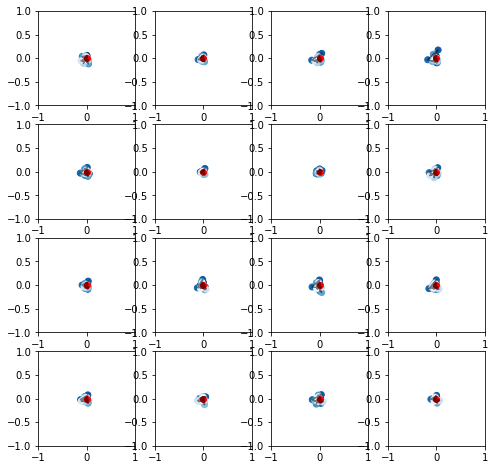

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.173217467772655, Dr : 0.0034232506385216345, Df : 0.004148020003086481


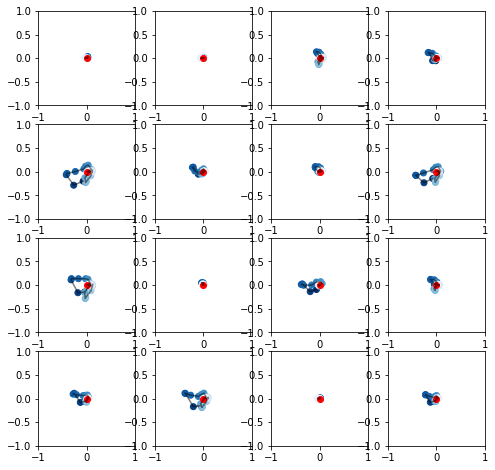

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.07773390183081993, Dr : 0.01931341412739876, Df : 0.01237662442219563


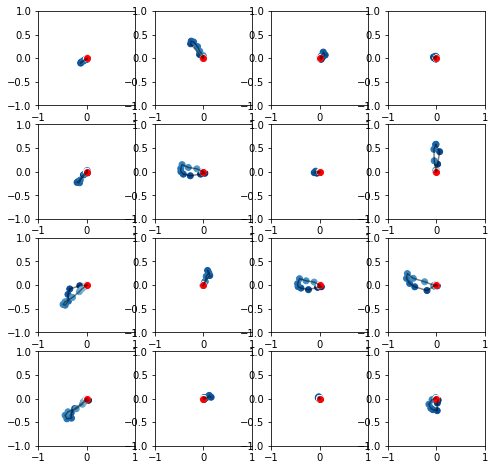

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.10142916593796168, Dr : 0.014101719627013573, Df : 0.007109889999414101


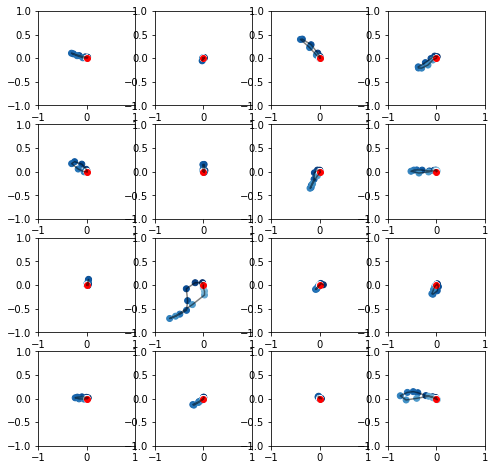

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.12065447293795072, Dr : 0.0037383845983407437, Df : 0.023763301853950206


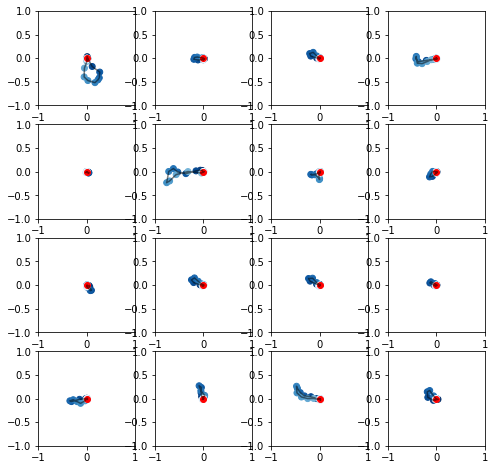

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.16739866672418055, Dr : 0.005194622736710768, Df : 0.011013819239078423


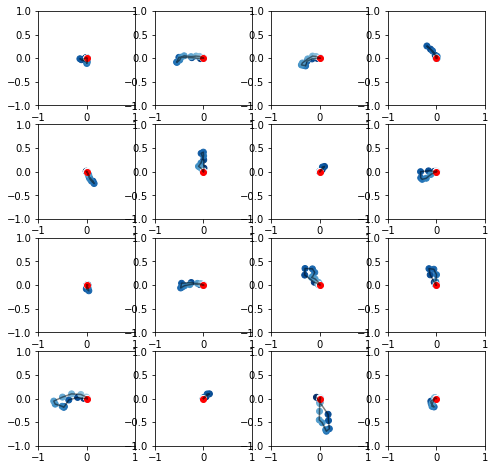

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.13496013176746857, Dr : 0.007932997093750881, Df : 0.012619610971365219


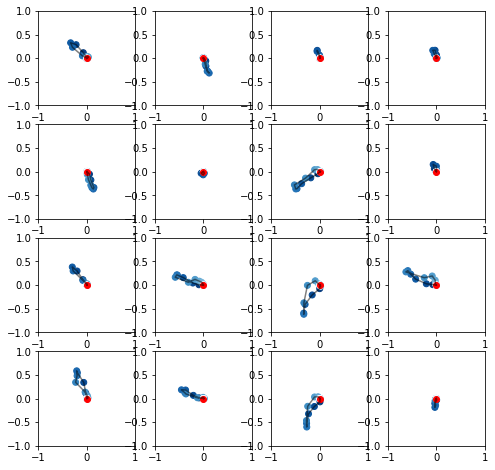

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.13139517490680402, Dr : 0.0029206965596247944, Df : 0.006349295186690795


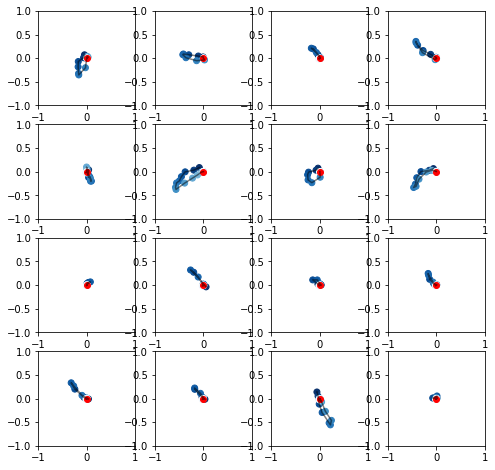

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.13605884405282828, Dr : 0.0010983130584160488, Df : 0.0017683696574889696


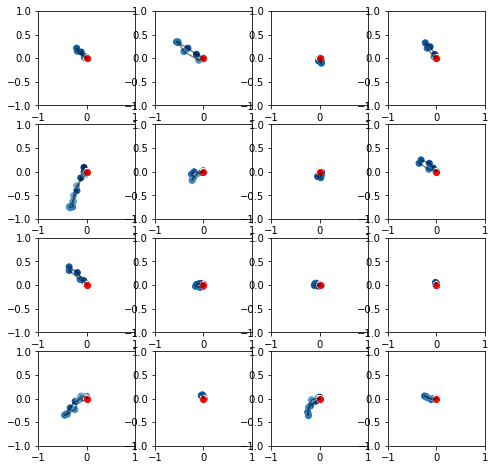

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.2720649059002216, Dr : 0.0015331513893145781, Df : 0.003103614999697759


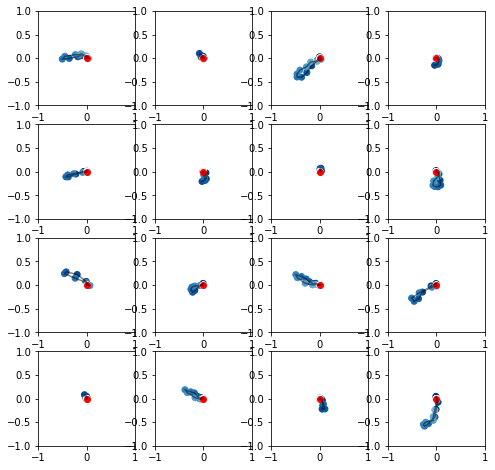

In [24]:
generator = CNNGenerator()
discriminator = CNNDiscriminator()

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

cnn_cnn = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

cnn_cnn.train(nb_epoch, lr, device)

# LSTM - LSTM


Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.038679723556225114, Dr : 0.03767984952682104, Df : 0.032566935588151984


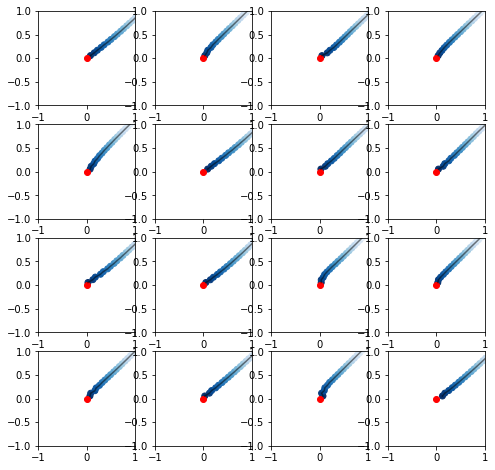

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.035472021653101996, Dr : 0.03553155140999036, Df : 0.03553826533831083


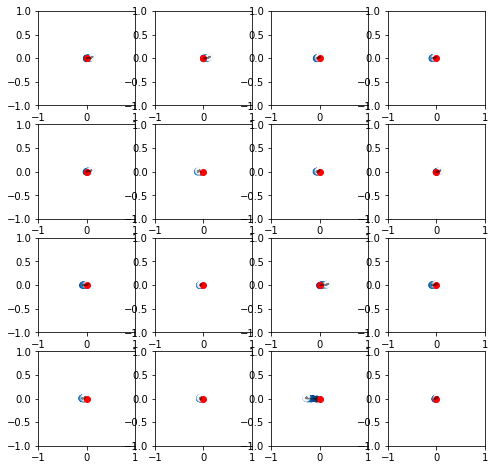

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.035439774011954285, Dr : 0.035480245565756775, Df : 0.03563699508324648


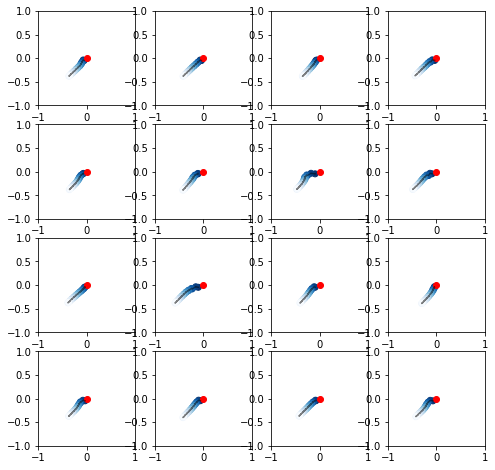

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.03551672666500776, Dr : 0.03552702145698743, Df : 0.0355683656839224


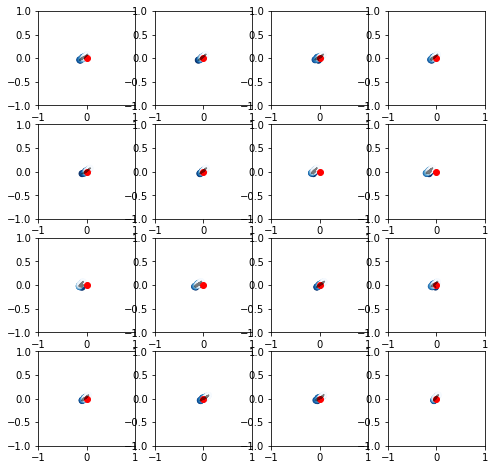

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.035567456331008517, Dr : 0.03557707713200496, Df : 0.035553304048684925


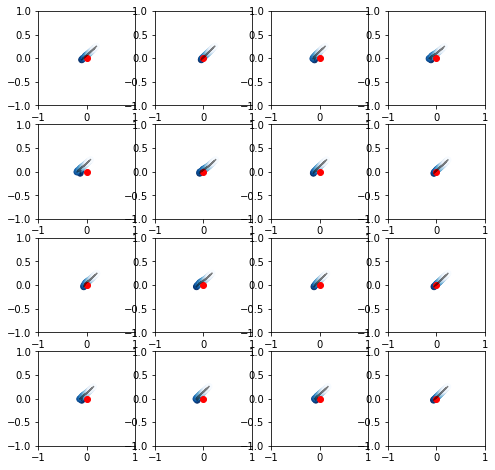

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.03555779426525801, Dr : 0.035543240033663236, Df : 0.03555095195770264


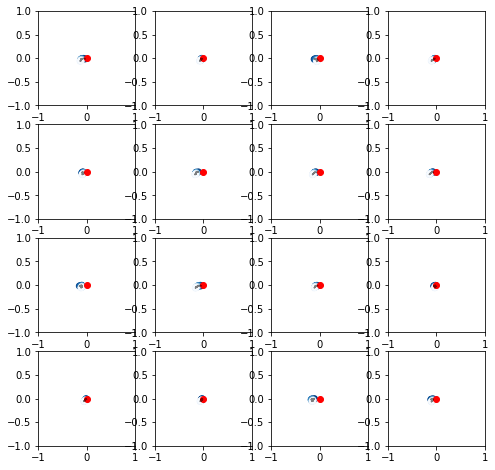

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.03554795797054584, Dr : 0.03554226496280768, Df : 0.03552807600070269


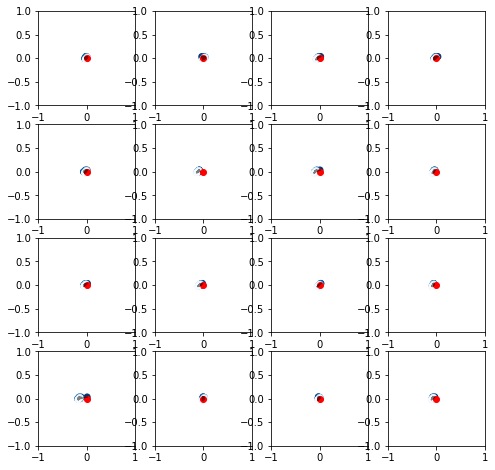

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.03551807923194689, Dr : 0.03555883199740679, Df : 0.03554390026972844


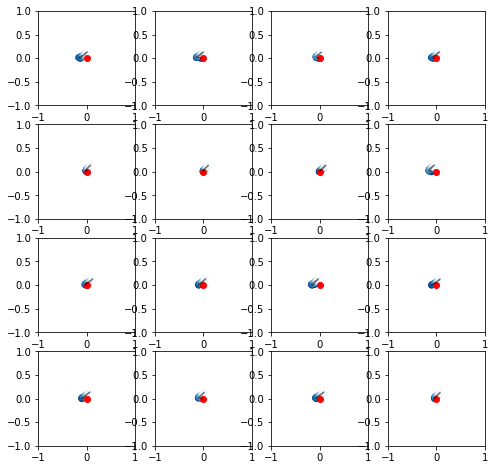

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.03564318326803354, Dr : 0.03561925735229101, Df : 0.03545042490347838


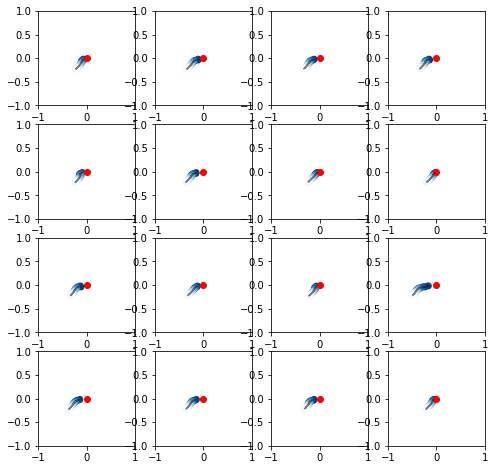

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.0355226932427822, Dr : 0.03546143036622267, Df : 0.03563380547058888


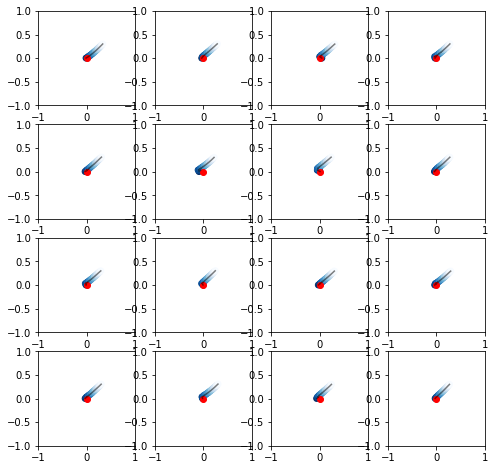

In [25]:
generator = LSTMGenerator().to(device)
discriminator = LSTMDiscriminator().to(device)

# ### WEIGHT INITIALIZATION
# generator.apply(weights_init)
# discriminator.apply(weights_init)

lstm_lstm = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

lstm_lstm.train(nb_epoch, lr, device)

# LSTM - CNN

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.043329121210636236, Dr : 0.03407919406890869, Df : 0.030007392932207156


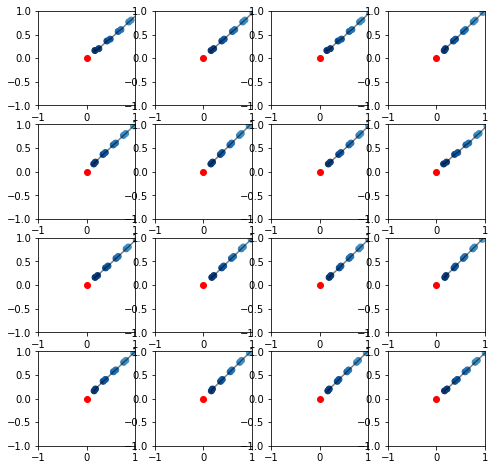

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.21602639173850036, Dr : 0.0008194192002216975, Df : 0.001330391145669497


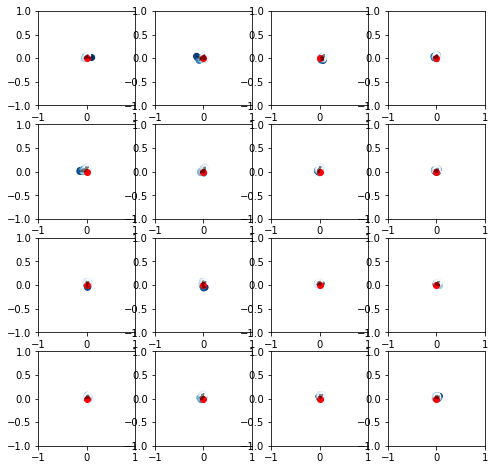

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.3467546120668069, Dr : 9.212396047913875e-05, Df : 0.0001226773736282037


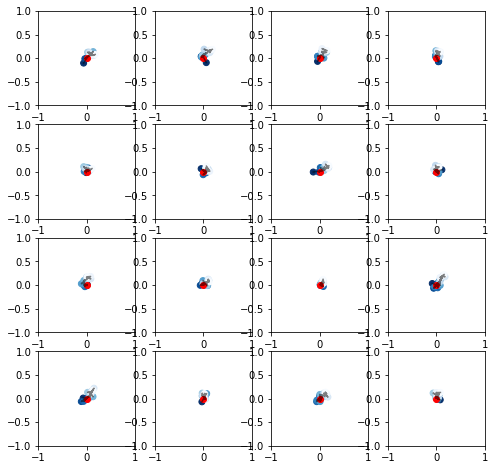

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.3839867542951535, Dr : 3.844106163925085e-05, Df : 4.2761247664785537e-05


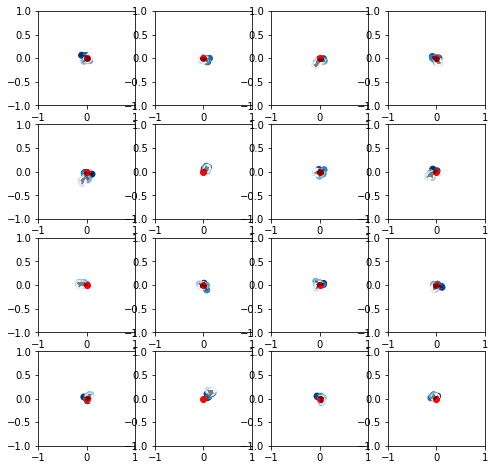

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.44057193169227016, Dr : 1.4694718023141226e-05, Df : 3.597527020013867e-05


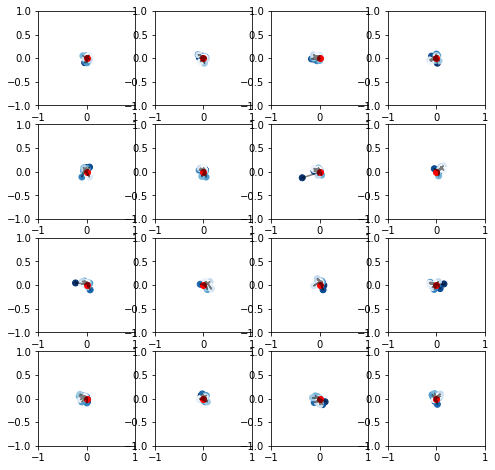

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.48285875564966446, Dr : 7.504360371221525e-06, Df : 7.120312194530971e-06


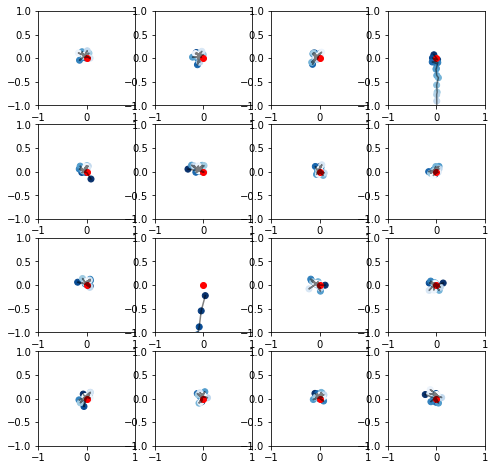

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.4467807916494516, Dr : 2.068220652663746e-05, Df : 2.0631248704515972e-05


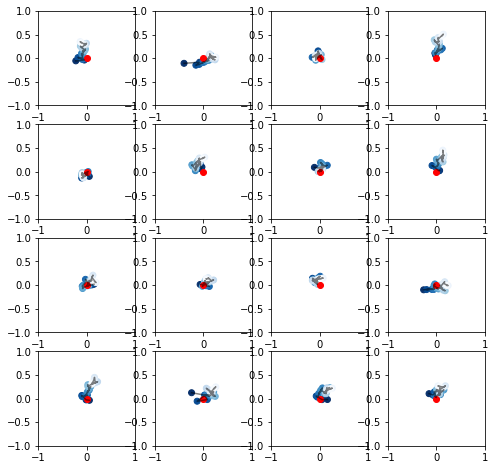

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.528836421477489, Dr : 2.9815620599457852e-06, Df : 3.5569248258327252e-06


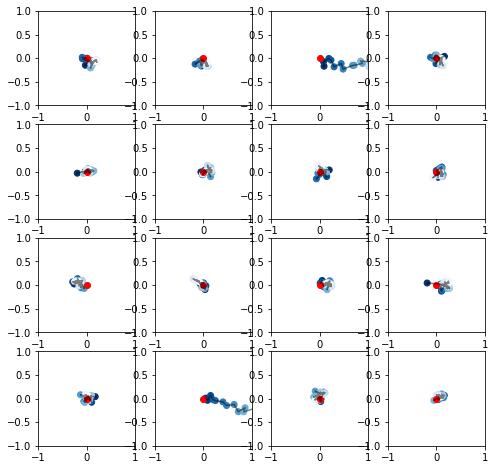

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.5456004509559045, Dr : 2.2551122618516765e-06, Df : 4.359438790766618e-06


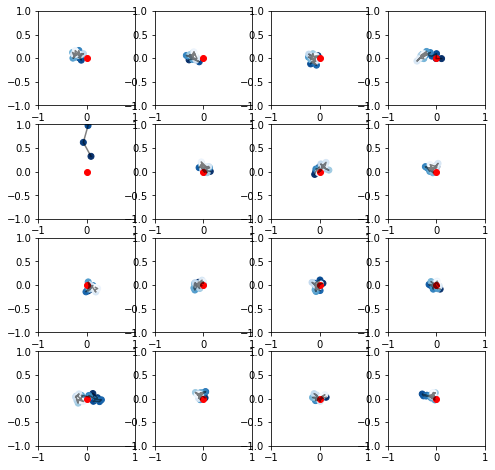

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.589141967969063, Dr : 1.6115780640691996e-06, Df : 1.2040273316252308e-06


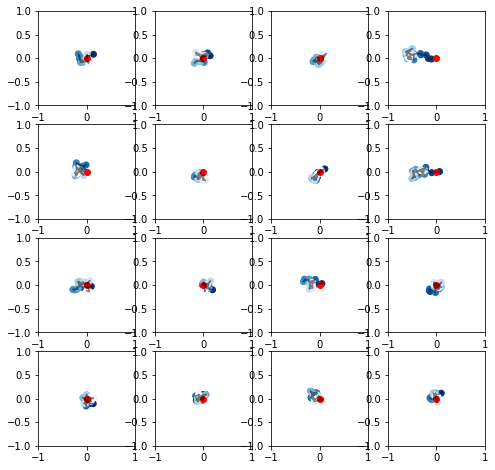

In [26]:
generator = LSTMGenerator().to(device)
discriminator = CNNDiscriminator().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

lstm_cnn = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

lstm_cnn.train(nb_epoch, lr, device)

# CNN - LSTM

Epoch [1/5000] -----------------------------------------------------------------------------
G: 0.03268382640985342, Dr : 0.0326266884803772, Df : 0.038624072686219826


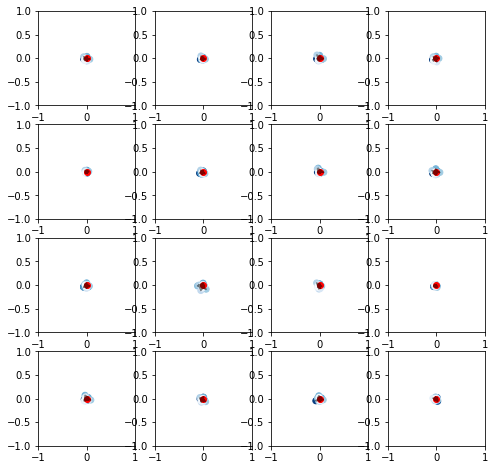

Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.03556115352190458, Dr : 0.035533261604798146, Df : 0.03552772142948248


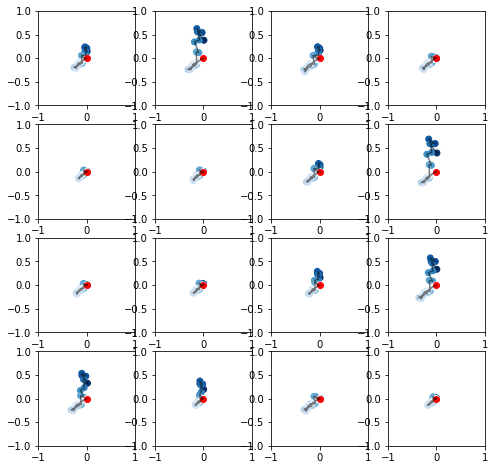

Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.03553151625853319, Dr : 0.035520729346153065, Df : 0.03555565919631567


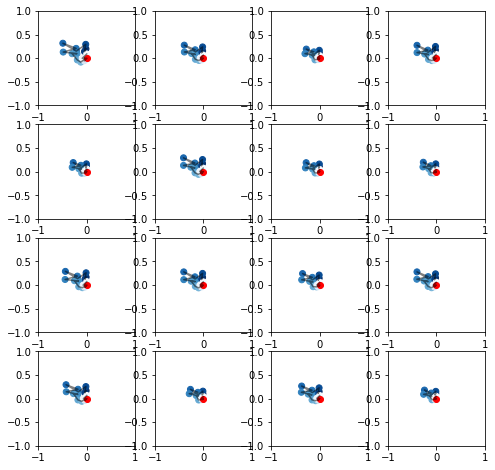

Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.03556687709612724, Dr : 0.035588207917335704, Df : 0.03551197968996488


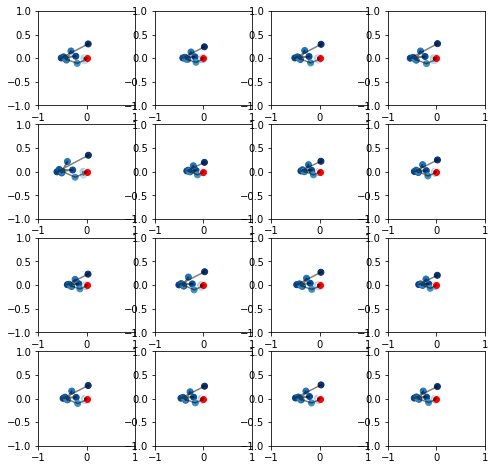

Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.03555781107682448, Dr : 0.035518928980216004, Df : 0.03553274961618277


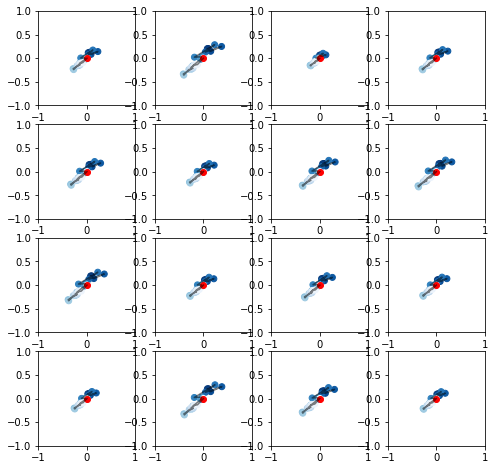

Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.035514480028397, Dr : 0.035537553139221974, Df : 0.03556189934412638


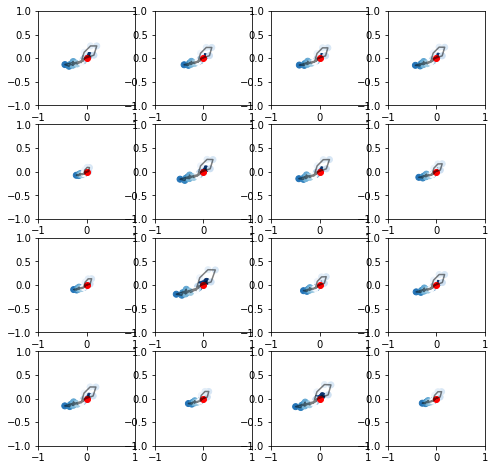

Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.035536487897237144, Dr : 0.03555688491234413, Df : 0.03556971213756464


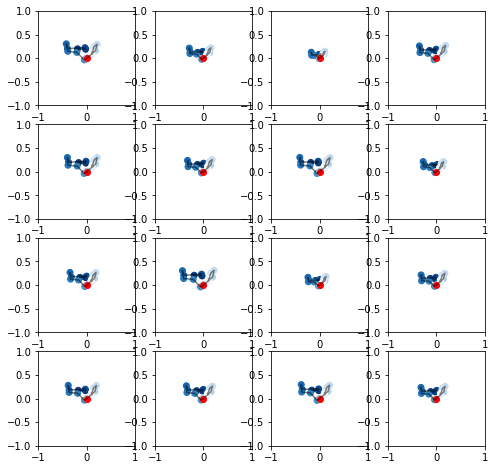

Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.03552941939769647, Dr : 0.035581591801765636, Df : 0.03553941158147959


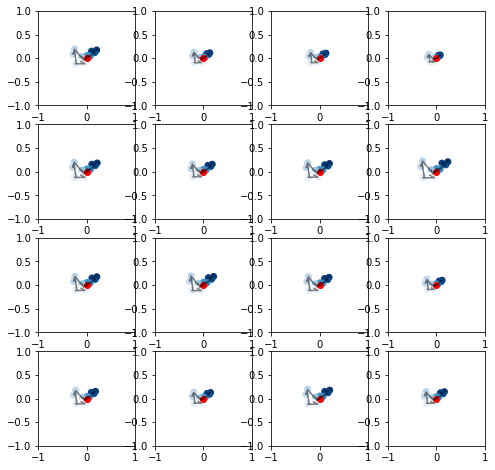

Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.03554910115706615, Dr : 0.03556607625423334, Df : 0.035566288691300615


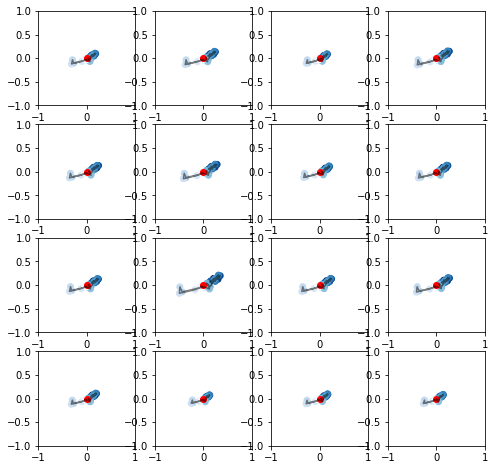

Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.035577610517159484, Dr : 0.03551051861200577, Df : 0.035546692518087536


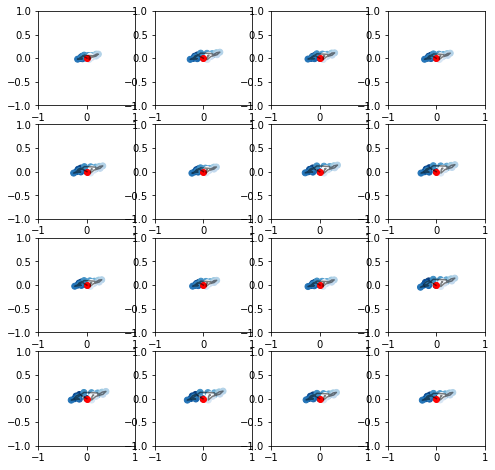

In [27]:
generator = CNNGenerator().to(device)
discriminator = LSTMDiscriminator().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

cnn_lstm = GAN(generator, discriminator, train_loader, device)

# Train the model
nb_epoch = 5000
lr = 0.0002

cnn_lstm.train(nb_epoch, lr, device)

# RESULTS


Text(0, 0.5, 'Score')

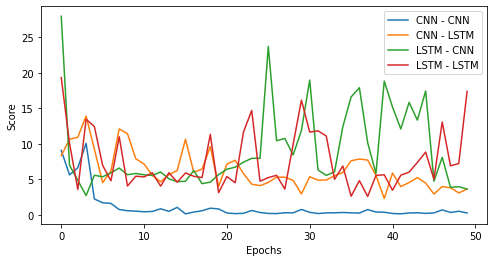

In [30]:
plt.figure(figsize=(8,4))
plt.plot(cnn_cnn.score, label = "CNN - CNN")
plt.plot(cnn_lstm.score, label = "CNN - LSTM")
plt.plot(lstm_cnn.score, label = "LSTM - CNN")
plt.plot(lstm_lstm.score, label = "LSTM - LSTM")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')

<BarContainer object of 4 artists>

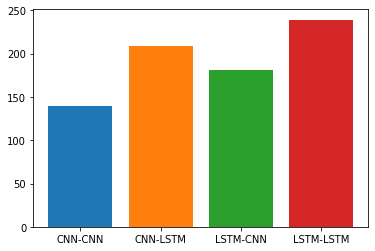

In [32]:
plt.bar(x = ['CNN-CNN', 'CNN-LSTM', 'LSTM-CNN', 'LSTM-LSTM'], 
        height = [cnn_cnn.computation_time, cnn_lstm.computation_time, lstm_cnn.computation_time,lstm_lstm.computation_time],
        color = [dicolour['blue'], dicolour['orange'], dicolour['green'], dicolour['red']])

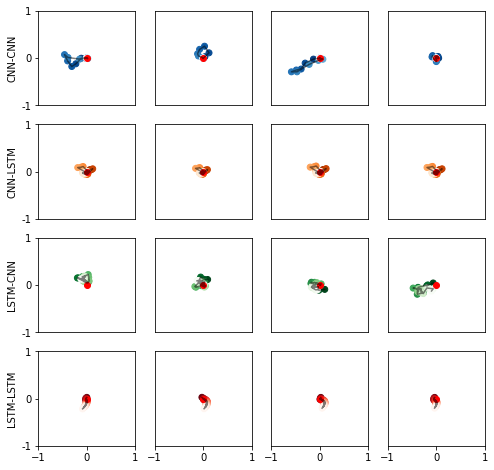

In [33]:
plt.figure(figsize=(8,8))

nb = 4
traj_sim = cnn_cnn.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('CNN-CNN')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)


nb = 4
traj_sim = cnn_lstm.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+4)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Oranges_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('CNN-LSTM')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)

nb = 4
traj_sim = lstm_cnn.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+8)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Greens_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('LSTM-CNN')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  if i >0:
    ax.axes.yaxis.set_visible(False)

nb = 4
traj_sim = lstm_lstm.test(nb)

for i in range(nb):
  plt.subplot(4,4,i+1+12)
  plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
  plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Reds_r')
  plt.scatter(0,0, c = 'red')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.yticks([-1, 0, 1], ["-1", "0", "1"])
  plt.ylabel('LSTM-LSTM')
  ax = plt.gca()
  if i >0:
    ax.axes.yaxis.set_visible(False)

In [34]:
cnn_cnn.save('cnn_cnn_20_steps_SV')
lstm_cnn.save('lstm_cnn_20_stepss_SV')
cnn_lstm.save('cnn_lstm_20_stepss_SV')
lstm_lstm.save('lstm_lstm_20_stepss_SV')